In [62]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

# pd.set_option("display.max_rows", None) 

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Importing random forest classifier from ensemble module
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestRegressor

# Import clustering model
from sklearn.metrics import accuracy_score, silhouette_score
from sklearn.cluster import KMeans


# Predicting Length of Hospital Stay
## Question: Can we predict the number of days a patient will stay in the hospital based on their medical condition, admission types, and treatment details?

- Target Variable: Length of stay <br>
- Modeling Approach: Regression (Linear Regression, Random Forest, XGBoost)<br>
- Hyperparameter Tuning: GridSearchCV or RandomizedSearchCV for tree-based models<br>
- Evaluation Metrics: RMSE, MAE, R² <br>

- Prediciting length of hospital stay given a particular medical condtion ?

In [42]:
# Load cleaned dataset
df = pd.read_csv('./data/healthcare_dataset_clean.csv')

In [17]:
df.head()

,Name,Age,Gender,Blood Type,Medical Condition,Date of Admission,Doctor,Hospital,Insurance Provider,Billing Amount,Room Number,Admission Type,Discharge Date,Medication,Test Results
0,bobby jackson,30,Male,B-,Cancer,2024-01-31,Matthew Smith,Sons and Miller,Blue Cross,18856.281306,328,Urgent,2024-02-02,Paracetamol,Normal
1,leslie terry,62,Male,A+,Obesity,2019-08-20,Samantha Davies,Kim Inc,Medicare,33643.327287,265,Emergency,2019-08-26,Ibuprofen,Inconclusive
2,danny smith,76,Female,A-,Obesity,2022-09-22,Tiffany Mitchell,Cook PLC,Aetna,27955.096079,205,Emergency,2022-10-07,Aspirin,Normal
3,andrew watts,28,Female,O+,Diabetes,2020-11-18,Kevin Wells,"Hernandez Rogers and Vang,",Medicare,37909.782410,450,Elective,2020-12-18,Ibuprofen,Abnormal
4,adrienne bell,43,Female,AB+,Cancer,2022-09-19,Kathleen Hanna,White-White,Aetna,14238.317814,458,Urgent,2022-10-09,Penicillin,Abnormal


# Feature Engineering

In [43]:
# Length of stay
d1 = pd.to_datetime(df['Date of Admission'])
d2 = pd.to_datetime(df['Discharge Date'])

length_of_stay = (d2-d1)

print(f'Average length of stay: {length_of_stay.mean().days} days')
print(f'Maximum length of stay: {length_of_stay.max().days} days')
print(f'Minimum length of stay: {length_of_stay.min().days} day')

# Add column to dataset
df['Length of Stay']= length_of_stay.dt.days

# Drop original date of admission and discharge to avoid data leakage?

Average length of stay: 15 days
Maximum length of stay: 30 days
Minimum length of stay: 1 day


In [71]:
df_encoded = df.copy()

# Drop irrelevant columns. Note remove Billing amount too as potential leak info/ highly correlated with length of stay
df_encoded.drop(df_encoded.columns.difference(['Age','Gender', 'Medical Condition', 'Admission Type', 'Length of Stay']),axis=1, inplace=True)
df_encoded.head()

,Age,Gender,Medical Condition,Admission Type,Length of Stay
0,30,Male,Cancer,Urgent,2
1,62,Male,Obesity,Emergency,6
2,76,Female,Obesity,Emergency,15
3,28,Female,Diabetes,Elective,30
4,43,Female,Cancer,Urgent,20


In [72]:
# One-hot encode categorical variables
df_encoded = pd.get_dummies(df_encoded, columns=['Medical Condition', 'Gender', 'Admission Type'], drop_first=True, dtype=int)


In [73]:
df_encoded.head()

,Age,Length of Stay,Medical Condition_Asthma,Medical Condition_Cancer,Medical Condition_Diabetes,Medical Condition_Hypertension,Medical Condition_Obesity,Gender_Male,Admission Type_Emergency,Admission Type_Urgent
0,30,2,0,1,0,0,0,1,0,1
1,62,6,0,0,0,0,1,1,1,0
2,76,15,0,0,0,0,1,0,1,0
3,28,30,0,0,1,0,0,0,0,0
4,43,20,0,1,0,0,0,0,0,1


# Train Model
- Target variable: Length of Stay

In [74]:
# Train/Test Split
X = df_encoded.drop(columns=['Length of Stay'])  
y = df_encoded['Length of Stay']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [57]:
# X.shape
y.shape

(50000,)

In [75]:
# Train model - random forest 
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [76]:
# Predict using test data 
y_pred = rf.predict(X_test)


In [77]:
# Finding the important features using the built-in Gini importance
feature_names = X.columns
importances = rf.feature_importances_
feature_imp_df = pd.DataFrame({'Feature': feature_names, 'Gini Importance': importances}).sort_values('Gini Importance', ascending=False)
feature_imp_df

,Feature,Gini Importance
0,Age,0.544353
6,Gender_Male,0.119155
7,Admission Type_Emergency,0.070854
3,Medical Condition_Diabetes,0.056558
2,Medical Condition_Cancer,0.054546
5,Medical Condition_Obesity,0.045788
8,Admission Type_Urgent,0.042072
4,Medical Condition_Hypertension,0.039399
1,Medical Condition_Asthma,0.027276


Text(0, 0.5, 'Features')

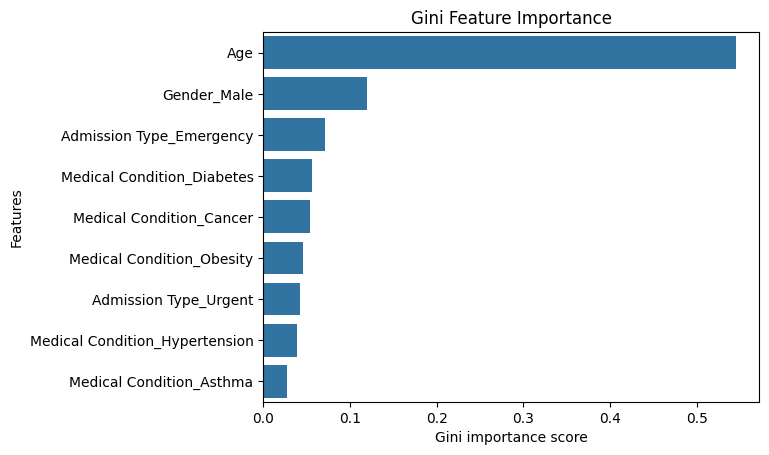

In [81]:
# Creating a seaborn bar plot of feature importance
sns.barplot(x=feature_imp_df['Gini Importance'],y=feature_imp_df['Feature'],data=feature_imp_df)
plt.title("Gini Feature Importance")
plt.xlabel("Gini importance score")
plt.ylabel("Features")

# Evaluate model

## Perform (K-Means) Clustering and determine if there are patterns in disease for length of stay patients - i.e. does a particular length of stay correlate to a certain medical condition and also if there are certain costs associated

does it generally cost more for a longer stay or does it depend on the medical condition?


# Research Question: 

Can we identify distinct patient groups based on their billing amounts? i.e. are higher costs associated with certain diseases?
Is there are correlation with length of stay, and do certain medical conditions lead to higher treatment costs than others? <br>
<br>

This could help hospital administrators optimise pricing strategies and resource allocation and nform policy makers about which are the most costly disease to treat.